# 引入OpenAI gym

In [1]:
import numpy as np
import os
import sys

%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt

In [2]:
import gym

In [3]:
env = gym.make("MsPacman-v0")

In [4]:
obs = env.reset()

In [5]:
obs.shape

(210, 160, 3)

In [6]:
img = env.render(mode="rgb_array")

<IPython.core.display.Javascript object>


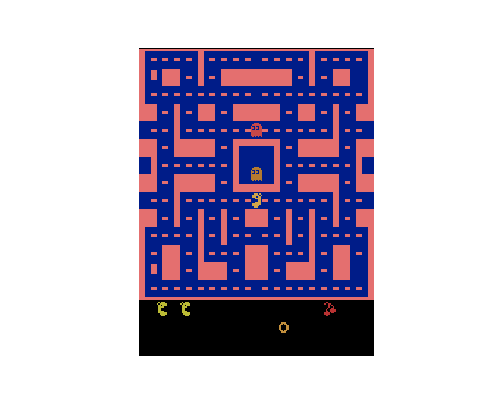

In [7]:
plt.figure(figsize=(5, 4))
plt.imshow(img)
plt.axis("off")
plt.show()

In [8]:
(img == obs).all()

True

In [9]:
def plot_environment(env, figsize=(5, 4)):
    plt.close()
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [10]:
env.action_space

Discrete(9)

<IPython.core.display.Javascript object>


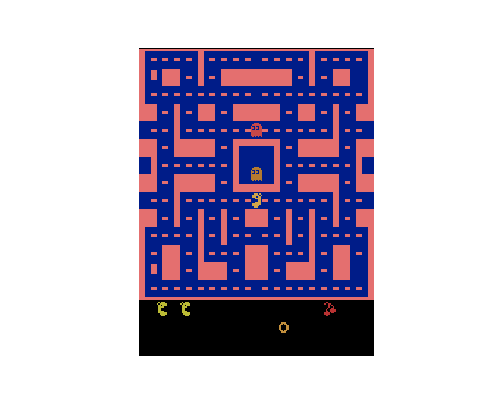

In [11]:
env.reset()
plot_environment(env)

In [12]:
for step in range(110):
    env.step(3) #left
for step in range(40):
    env.step(8) #lower-left

<IPython.core.display.Javascript object>


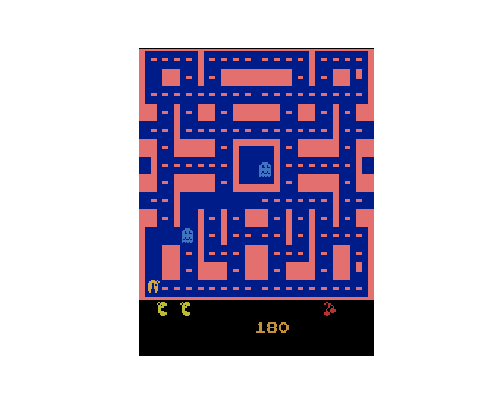

In [13]:
plot_environment(env)

In [14]:
obs, reward, done, info = env.step(0)

In [15]:
#observation告诉代理环境是什么样的
obs.shape #210*160RGB图像

(210, 160, 3)

In [16]:
#最后一步的得分
reward

0.0

In [17]:
#游戏结束 done=True
done

False

In [18]:
#额外信息
info

{'ale.lives': 3}

## 随机游玩

In [19]:
frames = []

n_max_steps = 1000
n_change_steps = 10
obs = env.reset()
for step in range(n_max_steps):
    img = env.render(mode="rgb_array")
    frames.append(img)
    if step % n_change_steps == 0:
        action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if done:
        break

In [20]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch

def plot_animation(frames, repeat=False, interval=40):
    plt.close()
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis("off")
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch),
                                  frames=len(frames), repeat=repeat, interval=interval)

<IPython.core.display.Javascript object>


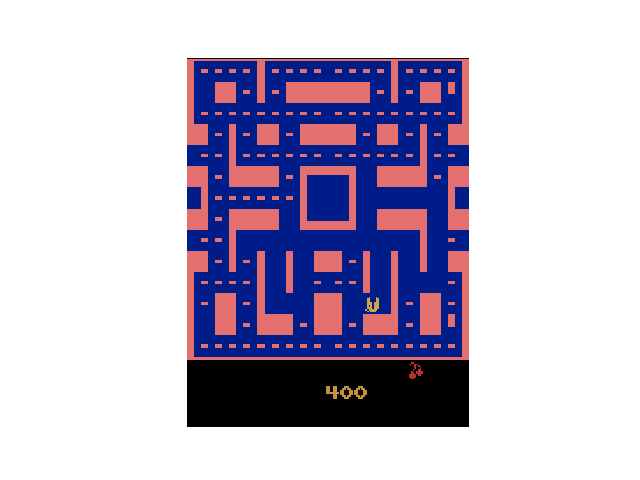

In [21]:
video = plot_animation(frames)
plt.show()

In [22]:
env.close()

## Cart-Pole

In [23]:
env = gym.make("CartPole-v0")
obs = env.reset()
obs

array([ 0.02148378,  0.0495718 , -0.00638272, -0.02910309])

### 修复渲染问题

In [24]:
from PIL import Image, ImageDraw

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True
except Exception:
    openai_cart_pole_rendering = False
    
def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        return env.render(mode="rgb_array")
    else:
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000
        pole_col = 0x669acc
        
        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len // 2 - pole_len * np.cos(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, 
                        cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col)
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y),
                 fill=pole_col, width=pole_w)
        return np.array(img)
    
def plot_cart_pole(env, obs):
    plt.close()
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

<IPython.core.display.Javascript object>


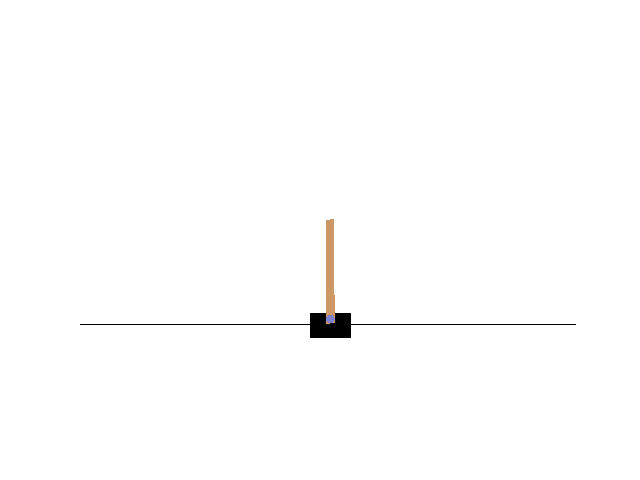

In [25]:
plot_cart_pole(env, obs)

In [26]:
env.action_space

Discrete(2)

In [27]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(0)
    if done:
        break

<IPython.core.display.Javascript object>


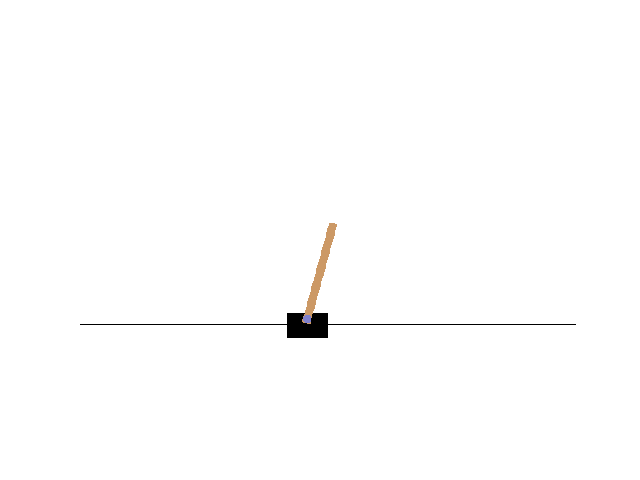

(-0.5, 599.5, 399.5, -0.5)

In [28]:
plt.close()
img = render_cart_pole(env, obs)
plt.imshow(img)
plt.axis("off")

In [28]:
img.shape

(210, 160, 3)

In [29]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(1)
    if done:
        break

<IPython.core.display.Javascript object>


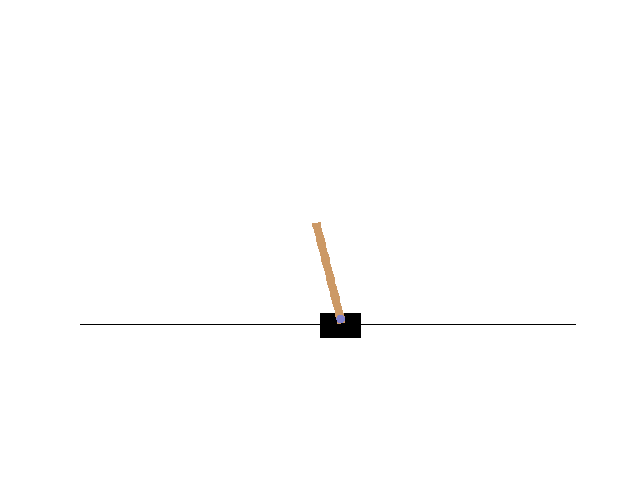

In [30]:
plot_cart_pole(env, obs)

### 硬编码策略

In [33]:
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    img = render_cart_pole(env, obs)
    frames.append(img)
    
    position, velocity, angle, angular_velocity = obs
    if angle < 0:
        action = 0
    else:
        action = 1
    obs, reward, done, info = env.step(action)
    if done:
        break

<IPython.core.display.Javascript object>


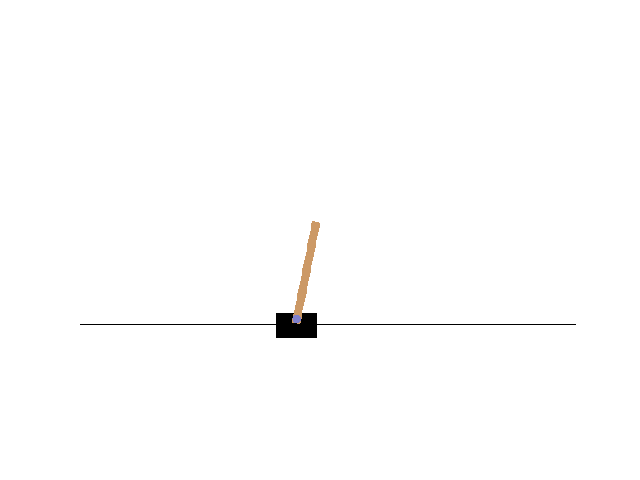

In [34]:
video = plot_animation(frames)
plt.show()

## 神经网络策略

In [36]:
import tensorflow as tf

n_inputs = 4
n_hidden = 4
n_outputs = 1
initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu,
                        kernel_initializer=initializer)
outputs = tf.layers.dense(hidden, n_outputs, activation=tf.nn.sigmoid,
                         kernel_initializer=initializer)

p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

init = tf.global_variables_initializer()

In [37]:
n_max_steps = 1000
frames = []

with tf.Session() as sess:
    init.run()
    obs = env.reset()
    for step in range(n_max_steps):
        img = render_cart_pole(env, obs)
        frames.append(img)
        action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
        obs, reward, done, info = env.step(action_val[0][0])
        if done:
            break
env.close()

<IPython.core.display.Javascript object>


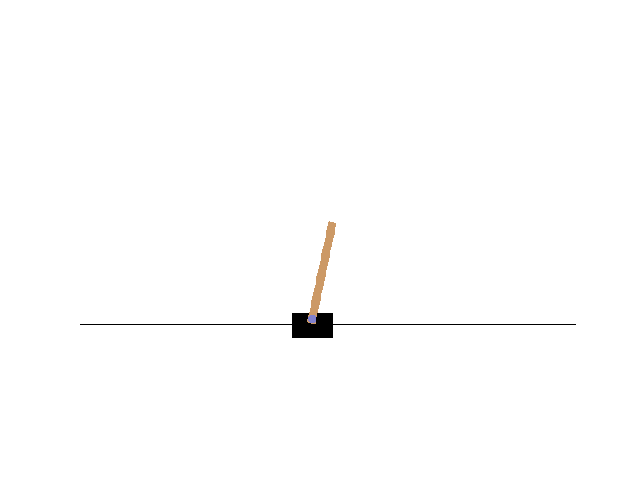

In [38]:
video = plot_animation(frames)
plt.show()

### 改进

In [39]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [40]:
import tensorflow as tf

reset_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

learning_rate = 0.01

initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.float32, shape=[None, n_outputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu,
                        kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits)
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cross_entropy)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [41]:
n_environments = 10
n_iterations = 1000

envs = [gym.make("CartPole-v0") for _ in range(n_environments)]
observations = [env.reset() for env in envs]

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        target_probas = np.array([([1.] if obs[2] < 0  else [0.]) 
                                 for obs in observations])
        action_val, _ = sess.run([action, training_op], 
                                 feed_dict={X: np.array(observations), y: target_probas})
        for env_index, env in enumerate(envs):
            obs, reward, done, info = env.step(action_val[env_index][0])
            observations[env_index] = obs if not done else env.reset()
    saver.save(sess, "reinforce/my_policy_net_basic.ckpt")

for env in envs:
    env.close()

In [42]:
def render_policy_net(model_path, action, X, n_max_steps = 1000):
    frames = []
    env = gym.make("CartPole-v0")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val  = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames

INFO:tensorflow:Restoring parameters from reinforce/my_policy_net_basic.ckpt


<IPython.core.display.Javascript object>


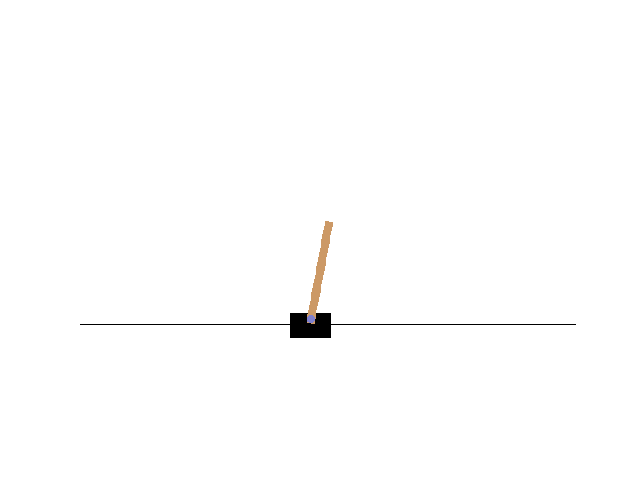

In [43]:
frames = render_policy_net("reinforce/my_policy_net_basic.ckpt", action, X)
video = plot_animation(frames)
plt.show()